In [ ]:
import copy
import itertools
import numpy as np
from collections import namedtuple
import time

Item = namedtuple("Item", ['id', 'size'])
Candidate = namedtuple("Candidate", ['items', 'fitness'])
bin_size = 50

In [ ]:
#------------BIN-------------
def cost(bins):
    return len(bins)

class Bin(object):
    count = itertools.count()
    def __init__(self, capacity):
        self.id = next(Bin.count)
        self.capacity = capacity
        self.free_space = capacity
        self.items = []
        self.used_space = 0

    def add_item(self, item):
        self.items.append(item)
        self.free_space -= item.size
        self.used_space += item.size

    def remove_item(self, item_index):
        item_to_remove = self.items[item_index]
        del self.items[item_index]
        self.free_space += item_to_remove.size
        self.used_space -= item_to_remove.size

    def fits(self, item):
        return self.free_space >= item.size

    def __str__(self):
        items = [str(it) for it in self.items]
        items_string = '[' + ' '.join(items) + ']'
        return "Bin n° " + str(self.id) + " containing the " + \
            str(len(self.items)) + " following items : " + items_string + \
            " with " + str(self.free_space) + " free space."

    def __copy__(self):
        new_bin = Bin(self.capacity)
        new_bin.free_space = self.free_space
        new_bin.used_space = self.used_space
        new_bin.items = self.items[:]
        return new_bin



In [ ]:
# choisir la solution initiale par l'algorithme de first fit
def firstfit(items, current_bins, capacity):
    bins = [copy.copy(b) for b in current_bins]
    if not bins:
        bins = [Bin(capacity)]
    for item in items:
        if item.size > capacity:
            continue
        first_bin = next((bin for bin in bins if bin.free_space >= item.size), None)
        if first_bin is None:
            bin = Bin(capacity)
            bin.add_item(item)
            bins.append(bin)
        else:
            first_bin.add_item(item)
    return bins


In [ ]:
# step 01 : Create initial Population
def population_generator(items, capacity, population_size):
    candidate = Candidate(items[:], fitness(items, capacity))
    population = [candidate]
    new_items = items[:]
    for i in range(population_size - 1):
        np.random.shuffle(new_items)
        candidate = Candidate(new_items[:], fitness(new_items, capacity))
        if candidate not in population:
            population.append(candidate)
    return population
# step 02 : calculate fitness for the candidate of this population
def fitness(candidate, capacity):
     return firstfit(candidate,[], capacity)

In [1]:
# step 03 : selection
# Selection par tournoi
def tournament_selection(population, tournament_selection_probability, k):
    candidates = [population[(np.random.randint(0, len(population) - 1))]]
    while len(candidates) < k:
        new_indiv = population[(np.random.randint(0, len(population) - 1))]
        if new_indiv not in candidates:
            candidates.append(new_indiv)
    ind = int(np.random.geometric(tournament_selection_probability, 1))
    while ind >= k:
        ind = int(np.random.geometric(tournament_selection_probability, 1))
    return candidates[ind]

# sélection par roue de roulette.
def roulette_wheel_selection(population):
    max = sum([len(e.fitness) for e in population])
    pick = np.random.uniform(0, max)
    current = max
    for item in population:
        current -= len(item.fitness)
        if current < pick:
            return item

# Selection par rang
def rank_selection(population):
    length = len(population)
    rank_sum = length * (length + 1) / 2
    pick = np.random.uniform(0, rank_sum)
    current = 0
    i = length
    for item in population:
        current += i
        if current > pick:
            return item
        i -= 1

# Stochastic Universal Sampling (SUS)
def SUS(population, n):
    selected = []
    pointers = []
    max = sum([len(e.fitness) for e in population])
    distance = max / n
    start = np.random.uniform(0, distance)
    for i in range(n):
        pointers.append(start + i * distance)
    for pointer in pointers:
        current = 0
        for item in population:
            current += len(item.fitness)
            if current > pointer:
                selected.append(item)
    return selected


In [2]:
# step 04 : crossover
def crossover(parent1, parent2):
    taken = [False] * len(parent1)
    child = []
    i = 0
    while i < len(parent1):
        element = parent1[i]
        if not taken[element.id]:
            child.append(element)
            taken[element.id] = True
        element = parent2[i]
        if not taken[element.id]:
            child.append(element)
            taken[element.id] = True
        i += 1
    return child


In [3]:
# step 05 : mutation
def mutation(member, capacity):
    member_items = member.items
    a = np.random.randint(0, len(member_items) - 1)
    b = np.random.randint(0, len(member_items) - 1)
    while a == b:
        b = np.random.randint(0, len(member_items) - 1)
    c = member_items[a]
    member_items[a] = member_items[b]
    member_items[b] = c
    member = Candidate(member_items, fitness(member_items, capacity))
    return member

In [4]:
# Definir l'algorithme genetique en suivant les steps mentionnés deja
def genetic_algorithm(weights, capacity, population_size, generations, k, tournament_selection_probability, crossover_probability, mutation_probability, allow_duplicate_parents, selection_method):
    items = [Item]
    items = [ Item(i,weights[i]) for i in range(len(weights))]

    population = population_generator(items, capacity, population_size)
    best_solution = fitness(items, capacity)
    i = 0

    while i < generations:
        new_generation = []
        best_child = best_solution
        for j in range(population_size):
            if selection_method == 'SUS': # Stochastic Universal Sampling (SUS)
                first_parent = SUS(population, 1)[0].items
                second_parent = SUS(population, 1)[0].items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = SUS(population, 1)[0].items
            elif selection_method == 'TS':
                first_parent = tournament_selection(population, tournament_selection_probability, k).items
                second_parent = tournament_selection(population, tournament_selection_probability, k).items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = tournament_selection(population, tournament_selection_probability, k).items
            elif selection_method == 'RW':  #roulette wheel selection
                first_parent = roulette_wheel_selection(population).items
                second_parent = roulette_wheel_selection(population).items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = roulette_wheel_selection(population).items
            elif selection_method == 'RS': #Selection par rang
                first_parent = rank_selection(population).items
                second_parent = rank_selection(population).items
                if not allow_duplicate_parents:
                    while first_parent == second_parent:
                        second_parent = rank_selection(population).items
            else:
                return

            child = crossover(first_parent, second_parent)
            child = Candidate(child[:], fitness(child, capacity))

            prob = np.random.rand()
            if prob <= mutation_probability:
                child = mutation(child, capacity)

            if len(child.fitness) < len(best_child):
                best_child = child.fitness
            new_generation.append(child)

        if len(best_child) < len(best_solution):
            best_solution = best_child
        population = [Candidate(p.items[:], p.fitness) for p in new_generation]
        population.sort(key=lambda candidate: len(candidate.fitness), reverse=True)
        i += 1

    return len(best_solution), [[item.size for item in bin.items] for bin in best_solution]



Defining parameters

In [ ]:
nb_objets =
population_size = 10
generations = 50
k =2
tournament_selection_probability = 0.7
crossover_probability = 0.8
mutation_probability = 0.1

Fonction de l'algorithme Genetique, qui va utiliser genetic algorithm avec les parametres

In [ ]:
def AG(benchmarkFileName):

    nb_objets=50
    with open(benchmarkFileName, "r") as ifile:
        items = []
        for i in range(nb_objets):
            line = ifile.readline().strip()
            if line:
                items.append(int(line))
        start_time = time.time()
        #genetic_algorithm(weights,capacity, population_size, generations, k, tournament_selection_probability, crossover_probability, mutation_probability, allow_duplicate_parents, selection_method):
        best_length, solution = genetic_algorithm(items, bin_size, population_size, generations, k,  tournament_selection_probability, crossover_probability,  mutation_probability, False, 'TS')
        end_time = time.time()
        execution_time = end_time - start_time

    return execution_time,best_length,solution



In [ ]:
# Pour le test en ce fichier
execution_time, best_length, solution =AG("/content/BPP_50_50_0.1_0.7_0.txt")
print("Execution Time:", execution_time)
print("Best Length:", best_length)
pop_size=population_size
print("Solution:",pop_size)

<ipython-input-97-78eeea6e03c2>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))
<ipython-input-97-78eeea6e03c2>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))


Execution Time: 0.5249872207641602
Best Length: 25
Solution: 10


La meilleure combinaison des parametres trouvée est:population_size = 10, generations = 50, k =2, tournament_selection_probability = 0.7
crossover_probability = 0.8, mutation_probability = 0.1 avec un nombre de bins = **23** et un temps d'execution = **0.09s**



# **1.   Tester le parametre Population_size**





In [ ]:
# Initialize an empty list to store results
all_results = []

# Define population sizes to test
population_sizes_to_test = [10, 20, 50,100]

# Run the AG function for each population size and save results
for pop_size in population_sizes_to_test:
    population_size = pop_size
    execution_time, best_length, solution = AG("/content/BPP_50_50_0.1_0.7_0.txt")
    result = {
        "Population Size": pop_size,
        "Execution Time": execution_time,
        "Best Length": best_length
    }
    all_results.append(result)

# After running all experiments, you'll have the results saved in the 'all_results' list
print(all_results)



<ipython-input-97-78eeea6e03c2>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))
<ipython-input-97-78eeea6e03c2>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))


[{'Population Size': 10, 'Execution Time': 0.7278711795806885, 'Best Length': 25}, {'Population Size': 20, 'Execution Time': 1.1669836044311523, 'Best Length': 25}, {'Population Size': 50, 'Execution Time': 1.1048939228057861, 'Best Length': 25}, {'Population Size': 100, 'Execution Time': 2.3425323963165283, 'Best Length': 25}]


Dessiner le graphe afin de choisir le parametre de Population_size

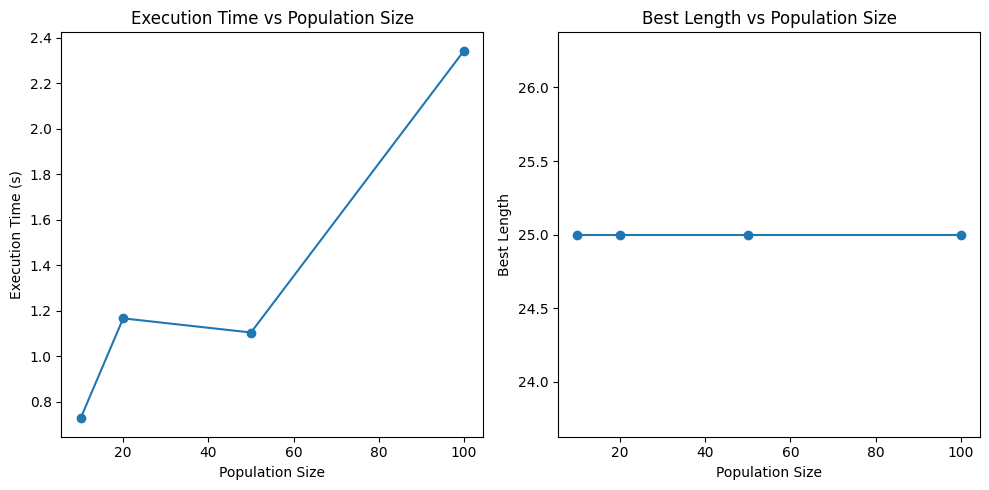

In [ ]:
import matplotlib.pyplot as plt

# Extract data from all_results
population_sizes = [result["Population Size"] for result in all_results]
execution_times = [result["Execution Time"] for result in all_results]
best_lengths = [result["Best Length"] for result in all_results]

# Plotting
plt.figure(figsize=(10, 5))

# Plot execution times
plt.subplot(1, 2, 1)
plt.plot(population_sizes, execution_times, marker='o')
plt.xlabel('Population Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Population Size')

# Plot best lengths
plt.subplot(1, 2, 2)
plt.plot(population_sizes, best_lengths, marker='o')
plt.xlabel('Population Size')
plt.ylabel('Best Length')
plt.title('Best Length vs Population Size')

plt.tight_layout()
plt.show()


Ici on a trouvé que le nombre de bins reste inchangé malgré les variations de la taille de population, par contre le temps d'execution augmente a chaque fois on augmente la taille du population.Donc la meilleure c'est 10.

# **2.   Tester le parametre Crossover_probability**
c'est pour le croissement

In [ ]:
# Initialize an empty list to store results
all_results = []

# Define population sizes to test
crossover_prob_to_test = [0.1, 0.3,0.4,0.5, 0.8]

# Run the AG function for each population size and save results
for prob in crossover_prob_to_test:
    crossover_probability = prob
    execution_time, best_length, solution = AG("/content/BPP_50_50_0.1_0.7_0.txt")
    result = {
        "crossover_prob": prob,
        "Execution Time": execution_time,
        "Best Length": best_length
    }
    all_results.append(result)

# After running all experiments, you'll have the results saved in the 'all_results' list
print(all_results)



<ipython-input-97-78eeea6e03c2>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))
<ipython-input-97-78eeea6e03c2>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))


[{'crossover_prob': 0.1, 'Execution Time': 1.4890754222869873, 'Best Length': 25}, {'crossover_prob': 0.3, 'Execution Time': 1.4616835117340088, 'Best Length': 25}, {'crossover_prob': 0.4, 'Execution Time': 1.364880084991455, 'Best Length': 25}, {'crossover_prob': 0.5, 'Execution Time': 1.396517038345337, 'Best Length': 25}, {'crossover_prob': 0.8, 'Execution Time': 1.2738251686096191, 'Best Length': 25}]


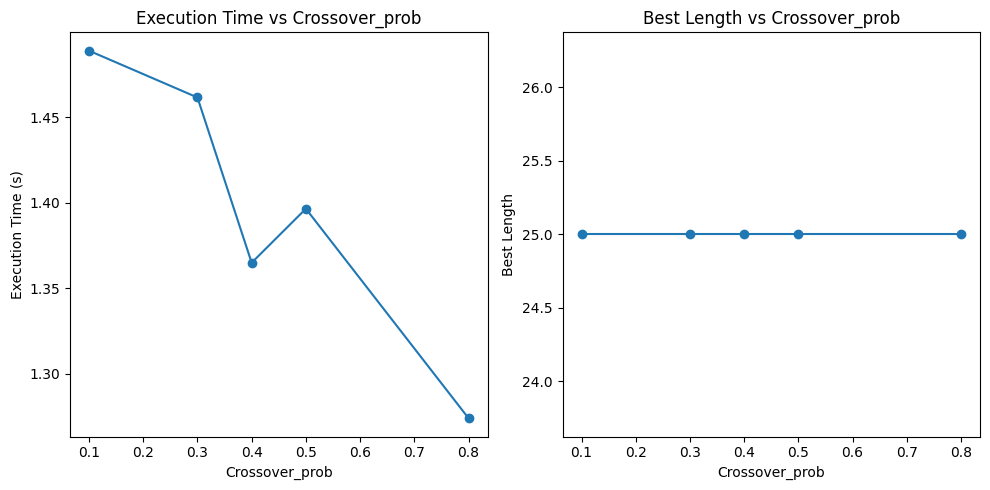

In [ ]:
import matplotlib.pyplot as plt

# Extract data from all_results
population_sizes = [result["crossover_prob"] for result in all_results]
execution_times = [result["Execution Time"] for result in all_results]
best_lengths = [result["Best Length"] for result in all_results]

# Plotting
plt.figure(figsize=(10, 5))

# Plot execution times
plt.subplot(1, 2, 1)
plt.plot(population_sizes, execution_times, marker='o')
plt.xlabel('Crossover_prob')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Crossover_prob')

# Plot best lengths
plt.subplot(1, 2, 2)
plt.plot(population_sizes, best_lengths, marker='o')
plt.xlabel('Crossover_prob')
plt.ylabel('Best Length')
plt.title('Best Length vs Crossover_prob')

plt.tight_layout()
plt.show()


On peut voir que le nombre de bins est toujours constant meme si on modifie la probabilité de croissement, par contre le temps d'exécution a chaque fois change mais on peut voir que avec le parametre 0.8 est beaucoup plus mieux

In [ ]:
 # Initialize an empty list to store results
all_results = []

# Define population sizes to test
mutation_to_test = [0.1, 0.3,0.4,0.5, 0.8]

# Run the AG function for each population size and save results
for prob in mutation_to_test:
    mutation_probability = prob
    execution_time, best_length, solution = AG("/content/BPP_50_50_0.1_0.7_0.txt")

    result = {
        "crossover_prob": prob,
        "Execution Time": execution_time,
        "Best Length": best_length
    }
    all_results.append(result)

# After running all experiments, you'll have the results saved in the 'all_results' list
print(all_results)



<ipython-input-97-78eeea6e03c2>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))
<ipython-input-97-78eeea6e03c2>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind = int(np.random.geometric(tournament_selection_probability, 1))


[{'crossover_prob': 0.1, 'Execution Time': 1.4793622493743896, 'Best Length': 25}, {'crossover_prob': 0.3, 'Execution Time': 5.183016777038574, 'Best Length': 25}, {'crossover_prob': 0.4, 'Execution Time': 1.4397785663604736, 'Best Length': 25}, {'crossover_prob': 0.5, 'Execution Time': 1.580794334411621, 'Best Length': 25}, {'crossover_prob': 0.8, 'Execution Time': 1.797516107559204, 'Best Length': 25}]


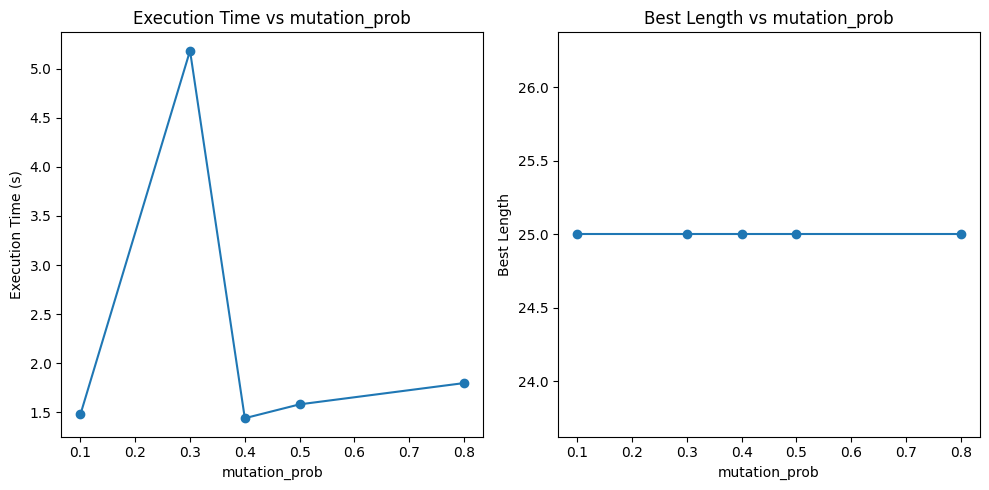

In [ ]:
import matplotlib.pyplot as plt

# Extract data from all_results
population_sizes = [result["crossover_prob"] for result in all_results]
execution_times = [result["Execution Time"] for result in all_results]
best_lengths = [result["Best Length"] for result in all_results]

# Plotting
plt.figure(figsize=(10, 5))

# Plot execution times
plt.subplot(1, 2, 1)
plt.plot(population_sizes, execution_times, marker='o')
plt.xlabel('mutation_prob')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs mutation_prob')

# Plot best lengths
plt.subplot(1, 2, 2)
plt.plot(population_sizes, best_lengths, marker='o')
plt.xlabel('mutation_prob')
plt.ylabel('Best Length')
plt.title('Best Length vs mutation_prob')

plt.tight_layout()
plt.show()


Par rapport a la probabilté du mutation, on peut voir que meme si on change la probabilté du mutation on a pas beaucoup de différence entre les temps d'execution, pour cela on va garder la probabilté du "0.1" qui a donné le petit temps d'exécution